In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import math
import os
from pathlib import Path
from tqdm import tqdm
from itertools import combinations
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from pmdarima.arima import ARIMA, auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Dense
import warnings
import logging

warnings.simplefilter("ignore")
mpl.rcParams[u'font.sans-serif'] = ['simhei']
mpl.rcParams['axes.unicode_minus'] = False
logging.basicConfig(level=logging.INFO)
err_log_handler = logging.FileHandler(filename="./results/arima_train_err_log.txt", mode='a')
err_logger = logging.getLogger("arima_train_err")
err_logger.addHandler(err_log_handler)


# %load_ext pycodestyle_magic
# %pycodestyle_on --ignore E501

time: 1.85 s (started: 2022-11-01 19:11:20 +00:00)


# Prepare data

In [2]:
# setting of output files
save_raw_corr_data = True
save_arima_resid_data = True
# data implement setting
data_implement = "paper_eva_5"  # tw50|sp500_20082017|sp500_19972007|tetuan_power
                                   # |sp500_20082017_consumer_discretionary
                                   # |paper_eva_1|paper_eva_2|paper_eva_3|paper_eva_4|paper_eva_5
# evaluation set setting
items_setting = "test"  # test|all
# data split period setting
time_period = "_test2"

time: 516 µs (started: 2022-11-01 19:11:22 +00:00)


In [3]:
# data loading & implement setting
dataset_path = Path("../dataset/")
if data_implement == "tw50":
    file_name = Path("tw50_hold_20082018_adj_close_pre.csv")
    train_set = ['萬海_adj_close', '豐泰_adj_close', '友達_adj_close', '欣興_adj_close', '台塑化_adj_close', '和泰車_adj_close', '元大金_adj_close', '南電_adj_close', '台塑_adj_close', '統一超_adj_close', '台泥_adj_close', '瑞昱_adj_close', '彰銀_adj_close', '富邦金_adj_close', '研華_adj_close', '中鋼_adj_close', '鴻海_adj_close', '台新金_adj_close', '遠傳_adj_close', '南亞_adj_close', '台達電_adj_close', '台灣大_adj_close', '台化_adj_close', '聯詠_adj_close', '廣達_adj_close', '聯發科_adj_close', '台積電_adj_close', '統一_adj_close', '中信金_adj_close', '長榮_adj_close']
elif data_implement == "sp500_19972007":
    file_name = Path("sp500_hold_19972007_adj_close_pre.csv")
    train_set = ['PXD', 'WAT', 'LH', 'AMGN', 'AOS', 'EFX', 'NEM', 'CTAS', 'MAT', 'VLO', 'APH', 'ADM', 'MLM', 'BK', 'NOV', 'BDX', 'RRC', 'IVZ', 'ED', 'SBUX', 'CI', 'ZION', 'COO', 'FDX', 'GLW', 'GPC', 'HPQ', 'ADI', 'AMG', 'MTB', 'YUM', 'SYK', 'KMX', 'AME', 'BMY', 'KMB', 'JPM', 'AET', 'DLTR', 'MGM', 'FL', 'HD', 'CLX', 'OKE', 'WMB', 'IFF', 'CMS', 'MMC', 'REG', 'ES', 'ITW', 'VRTX', 'QCOM', 'MSI', 'NKTR', 'AMAT', 'BWA', 'ESRX', 'TXT', 'VNO', 'WDC', 'PVH', 'NOC', 'PCAR', 'NSC', 'PHM', 'LUV', 'HUM', 'SPG', 'SJM', 'ABT', 'ALK', 'TAP', 'CAT', 'TMO', 'AES', 'MRK', 'RMD', 'MKC', 'HIG', 'DE', 'ATVI', 'O', 'UNM', 'VMC', 'CMA', 'RHI', 'RE', 'FMC', 'MU', 'CB', 'LNT', 'GE', 'SNA', 'LLY', 'LEN', 'MAA', 'OMC', 'F', 'APA', 'CDNS', 'SLG', 'HP', 'SHW', 'AFL', 'STT', 'PAYX', 'AIG']
elif data_implement in ["sp500_20082017", "paper_eva_1", "paper_eva_2", "paper_eva_3", "paper_eva_4", "paper_eva_5"]:
    file_name = Path("sp500_hold_20082017_adj_close_pre.csv")
    train_set = ['CELG', 'PXD', 'WAT', 'LH', 'AMGN', 'AOS', 'EFX', 'CRM', 'NEM', 'JNPR', 'LB', 'CTAS', 'MAT', 'MDLZ', 'VLO', 'APH', 'ADM', 'MLM', 'BK', 'NOV', 'BDX', 'RRC', 'IVZ', 'ED', 'SBUX', 'GRMN', 'CI', 'ZION', 'COO', 'TIF', 'RHT', 'FDX', 'LLL', 'GLW', 'GPN', 'IPGP', 'GPC', 'HPQ', 'ADI', 'AMG', 'MTB', 'YUM', 'SYK', 'KMX', 'AME', 'AAP', 'DAL', 'A', 'MON', 'BRK', 'BMY', 'KMB', 'JPM', 'CCI', 'AET', 'DLTR', 'MGM', 'FL', 'HD', 'CLX', 'OKE', 'UPS', 'WMB', 'IFF', 'CMS', 'ARNC', 'VIAB', 'MMC', 'REG', 'ES', 'ITW', 'NDAQ', 'AIZ', 'VRTX', 'CTL', 'QCOM', 'MSI', 'NKTR', 'AMAT', 'BWA', 'ESRX', 'TXT', 'EXR', 'VNO', 'BBT', 'WDC', 'UAL', 'PVH', 'NOC', 'PCAR', 'NSC', 'UAA', 'FFIV', 'PHM', 'LUV', 'HUM', 'SPG', 'SJM', 'ABT', 'CMG', 'ALK', 'ULTA', 'TMK', 'TAP', 'SCG', 'CAT', 'TMO', 'AES', 'MRK', 'RMD', 'MKC', 'WU', 'ACN', 'HIG', 'TEL', 'DE', 'ATVI', 'O', 'UNM', 'VMC', 'ETFC', 'CMA', 'NRG', 'RHI', 'RE', 'FMC', 'MU', 'CB', 'LNT', 'GE', 'CBS', 'ALGN', 'SNA', 'LLY', 'LEN', 'MAA', 'OMC', 'F', 'APA', 'CDNS', 'SLG', 'HP', 'XLNX', 'SHW', 'AFL', 'STT', 'PAYX', 'AIG', 'FOX', 'MA']
elif data_implement == "tetuan_power":
    file_name = Path("Tetuan City power consumption_pre.csv")
    train_set = ["Temperature", "Humidity", "Wind Speed", "general diffuse flows", "diffuse flows", "Zone 1 Power Consumption", "Zone 2 Power Consumption", "Zone 3 Power Consumption"]
elif data_implement == "bitcoin_nvda":
    file_name = Path("bitcoin_nvda_20122022_pre.csv")
    train_set = []
elif data_implement == "sp500_20082017_consumer_discretionary":
    file_name = Path("sp500_hold_20082017_adj_close_pre_consumer_discretionary.csv")
    train_set = ['LKQ', 'LEN', 'TGT', 'YUM', 'TJX', 'GRMN', 'MCD', 'DRI', 'HBI', 'GPS', 'SBUX', 'TSCO', 'WYN', 'MGM', 'MAT', 'ROST', 'IPG', 'PVH', 'VFC', 'EXPE', 'JWN', 'GPC', 'DIS', 'FL', 'AAP', 'KSS', 'TIF', 'HAS', 'DHI', 'MHK', 'UAA', 'KMX', 'BBY', 'CMCSA', 'LEG', 'VIAB', 'CCL', 'LB', 'HOG', 'F', 'AZO', 'RL', 'DISCA', 'FOXA', 'PHM', 'AMZN', 'WHR', 'NKE', 'SNA', 'M', 'FOX', 'ULTA', 'GT', 'CMG', 'LOW', 'TWX', 'HD', 'CBS']

dataset_df = pd.read_csv(dataset_path/file_name)
dataset_df = dataset_df.set_index('Date')
all_set = list(dataset_df.columns.values)  # all data
test_set = [p for p in all_set if p not in train_set]  # all data - train data
logging.info(f"===== len(train_set): {len(train_set)}, len(all_set): {len(all_set)}, len(test_set): {len(test_set)} =====")

# evaluation set setting
if items_setting == "all":
    items_set = all_set
    output_set_name = "_all"
elif items_setting == "test":
    items_set = test_set
    output_set_name = "_test"

evaluation_info = {"paper_eva_1": {"items": ['PRGO', 'MRO', 'ADP', 'HCP', 'FITB', 'PEG', 'SYMC', 'EOG', 'MDT', 'NI'], "output_file_name_basis": "paper_eva_1_res"},
                   "paper_eva_2": {"items": ['STI', 'COP', 'MCD', 'AON', 'JBHT', 'DISH', 'GS', 'LRCX', 'CTXS', 'LEG'], "output_file_name_basis": "paper_eva_2_res"},
                   "paper_eva_3": {"items": ['TJX', 'EMN', 'JCI', 'C', 'BIIB', 'HOG', 'PX', 'PH', 'XEC', 'JEC'], "output_file_name_basis": "paper_eva_3_res"},
                   "paper_eva_4": {"items": ['ROP', 'AZO', 'URI', 'TROW', 'CMCSA', 'SLB', 'VZ', 'MAC', 'ADS', 'MCK'], "output_file_name_basis": "paper_eva_4_res"},
                   "paper_eva_5": {"items": ['RL', 'CVX', 'SRE', 'PFE', 'PCG', 'UTX', 'NTRS', 'INCY', 'COP', 'HRL'], "output_file_name_basis": "paper_eva_5_res"},
                   "tw50": {"items": items_set, "file_name": f"tw50_20082017_res"},
                   "sp500_19972007": {"items": items_set, "output_file_name_basis": f"sp500_19972007_res"},
                   "sp500_20082017": {"items": items_set, "output_file_name_basis": f"sp500_20082017_res"},
                   "tetuan_power": {"items": items_set, "output_file_name_basis":  f"tetuan_power_res"},
                   "bitcoin_nvda": {"items": items_set, "output_file_name_basis":  f"bicoin_nvda_res"},
                   "sp500_20082017_consumer_discretionary": {"items": items_set, "output_file_name_basis":  f"sp500_20082017_consumer_discretionary_res"}}
items_implement = evaluation_info[data_implement]['items']
logging.info(f"===== len(predict set): {len(items_implement)} =====")

# lstm weight setting
lstm_only_weight_path = Path("./models/")
lstm_weight_filepath = lstm_only_weight_path/"20221101/Kristian_Senneset_LSTM_hyper_params/sp500_20082017_train_LSTM_only_epoch_382.h5"
lstm_weight_name = "_sp500_20082017LSTM_only"
logging.info(f"===== LSTM weight:{lstm_weight_name} =====")

# setting of name of output files and pictures title
output_file_name = evaluation_info[data_implement]["output_file_name_basis"] + output_set_name + time_period + lstm_weight_name
fig_title = data_implement + output_set_name + time_period + lstm_weight_name
logging.info(f"===== file_name basis:{output_file_name}, fig_title basis:{fig_title} =====")

# display(dataset_df)
# display(all_set)

INFO:root:===== len(train_set): 150, len(all_set): 446, len(test_set): 296 =====
INFO:root:===== len(predict set): 10 =====
INFO:root:===== LSTM weight:_sp500_20082017LSTM_only =====
INFO:root:===== file_name basis:paper_eva_5_res_test_test2_sp500_20082017LSTM_only, fig_title basis:paper_eva_5_test_test2_sp500_20082017LSTM_only =====


time: 107 ms (started: 2022-11-01 19:11:22 +00:00)


In [4]:
corr_window = 100
corr_stride = 100
data_length = int(len(dataset_df)/corr_window)*corr_window
corr_ind = list(range(99, 2400, corr_stride))  + list(range(99+20, 2500, corr_stride)) + \
           list(range(99+40, 2500, corr_stride)) + list(range(99+60, 2500, corr_stride)) + \
           list(range(99+80, 2500, corr_stride))  # only suit for settings of paper

corr_series_length = int((data_length-corr_window)/corr_stride)
corr_series_length_paper = 21  # only suit for settings of paper
data_diverse_stride = 20  # only suit for settings of paper
data_diverse_start_dates = [99 + d for d in range(0,100,data_diverse_stride)]  # only suit for settings of paper

time: 718 µs (started: 2022-11-01 19:11:22 +00:00)


In [5]:
def gen_unseen_data_corr(item_pair: list, time_period:str = "_test2") -> "pd.DataFrame, pd.Series | pd.DataFrame":
    tmp_corr = dataset_df[item_pair[0]].rolling(window=corr_window).corr(dataset_df[item_pair[1]])
    tmp_corr = tmp_corr.iloc[data_diverse_start_dates[0]::corr_stride]
    if time_period == "_test2":
        corr_series = tmp_corr[3:24] # correspond to test2_dataset of original paper
    elif time_period == "_test1" :
        corr_series = tmp_corr[2:23] # correspond to test1_dataset of original paper
    elif time_period == "_dev":
        corr_series = tmp_corr[1:22] # correspond to dev_dataset of original paper
    elif time_period == "_train":
        corr_series = tmp_corr[:21] # correspond to train_dataset of original papaer 
    unseen_data_df = pd.DataFrame(corr_series).T
    unseen_data_df.index = [f"{item_pair[0]} & {item_pair[1]}"]
    return unseen_data_df

time: 710 µs (started: 2022-11-01 19:11:22 +00:00)


In [6]:
display(gen_unseen_data_corr([items_implement[0], items_implement[1]], time_period="_test2"))
display(gen_unseen_data_corr([items_implement[0], items_implement[1]], time_period="_test1"))
display(gen_unseen_data_corr([items_implement[0], items_implement[1]], time_period="_dev"))
display(gen_unseen_data_corr([items_implement[0], items_implement[1]], time_period="_train"))

Date,2009-08-03,2009-12-23,2010-05-19,2010-10-11,2011-03-04,2011-07-27,2011-12-16,2012-05-11,2012-10-03,2013-03-01,...,2013-12-13,2014-05-09,2014-10-01,2015-02-25,2015-07-20,2015-12-09,2016-05-04,2016-09-26,2017-02-17,2017-07-12
RL & CVX,0.301064,0.870396,0.895088,0.803884,0.763552,0.437946,0.671847,0.239142,0.703358,0.74433,...,0.396555,0.246283,0.103744,0.01833,0.188772,0.739464,-0.214199,0.285949,-0.352241,0.32908


Date,2009-03-11,2009-08-03,2009-12-23,2010-05-19,2010-10-11,2011-03-04,2011-07-27,2011-12-16,2012-05-11,2012-10-03,...,2013-07-24,2013-12-13,2014-05-09,2014-10-01,2015-02-25,2015-07-20,2015-12-09,2016-05-04,2016-09-26,2017-02-17
RL & CVX,0.64202,0.301064,0.870396,0.895088,0.803884,0.763552,0.437946,0.671847,0.239142,0.703358,...,0.750612,0.396555,0.246283,0.103744,0.01833,0.188772,0.739464,-0.214199,0.285949,-0.352241


Date,2008-10-15,2009-03-11,2009-08-03,2009-12-23,2010-05-19,2010-10-11,2011-03-04,2011-07-27,2011-12-16,2012-05-11,...,2013-03-01,2013-07-24,2013-12-13,2014-05-09,2014-10-01,2015-02-25,2015-07-20,2015-12-09,2016-05-04,2016-09-26
RL & CVX,0.305758,0.64202,0.301064,0.870396,0.895088,0.803884,0.763552,0.437946,0.671847,0.239142,...,0.74433,0.750612,0.396555,0.246283,0.103744,0.01833,0.188772,0.739464,-0.214199,0.285949


Date,2008-05-23,2008-10-15,2009-03-11,2009-08-03,2009-12-23,2010-05-19,2010-10-11,2011-03-04,2011-07-27,2011-12-16,...,2012-10-03,2013-03-01,2013-07-24,2013-12-13,2014-05-09,2014-10-01,2015-02-25,2015-07-20,2015-12-09,2016-05-04
RL & CVX,-0.049737,0.305758,0.64202,0.301064,0.870396,0.895088,0.803884,0.763552,0.437946,0.671847,...,0.703358,0.74433,0.750612,0.396555,0.246283,0.103744,0.01833,0.188772,0.739464,-0.214199


time: 39 ms (started: 2022-11-01 19:11:22 +00:00)


# LSTM

In [7]:
def double_tanh(x):
    return (tf.math.tanh(x) * 2)


lstm_model = load_model(lstm_weight_filepath, custom_objects={'double_tanh':double_tanh})

2022-11-01 19:11:22.844073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 19:11:22.846828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 19:11:22.846991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 19:11:22.847259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

time: 762 ms (started: 2022-11-01 19:11:22 +00:00)


# Hybrid model

In [8]:
def stl_decompn(corr_series: "pd.Series", overview: bool = False) -> (float, float, float):
    output_resid = 100000
    output_trend = None
    output_period = None
    for p in range(2, 11):
        decompose_result_mult = seasonal_decompose(corr_series, period=p)
        resid_sum = np.abs(decompose_result_mult.resid).sum()
        if output_resid > resid_sum:
            output_resid = resid_sum
            output_trend = decompose_result_mult.trend.dropna()
            output_period = p

    reg = LinearRegression().fit(np.arange(len(output_trend)).reshape(-1, 1), output_trend)

    if overview:
        decompose_result_mult = seasonal_decompose(corr_series, period=output_period)
        trend = decompose_result_mult.trend.dropna().reset_index(drop=True)
        plt.figure(figsize=(7, 1))
        plt.plot(trend)
        plt.plot([0, len(trend)], [reg.intercept_, reg.intercept_+ len(trend)*reg.coef_])
        plt.title("trend & regression line")
        plt.show()
        plt.close()
        decompose_result_mult_fig = decompose_result_mult.plot()
        decompose_result_mult_fig .set_size_inches(10, 12, forward=True)
        for ax in decompose_result_mult_fig.axes:
            ax.tick_params(labelrotation=60) # Rotates X-Axis Ticks by 45-degrees
            ax.grid()
        plt.show()
        plt.close()

    return output_period, output_resid, output_trend.std(), reg.coef_[0]

time: 998 µs (started: 2022-11-01 19:11:23 +00:00)


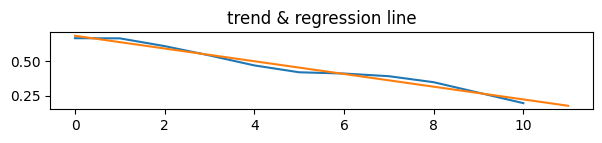

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

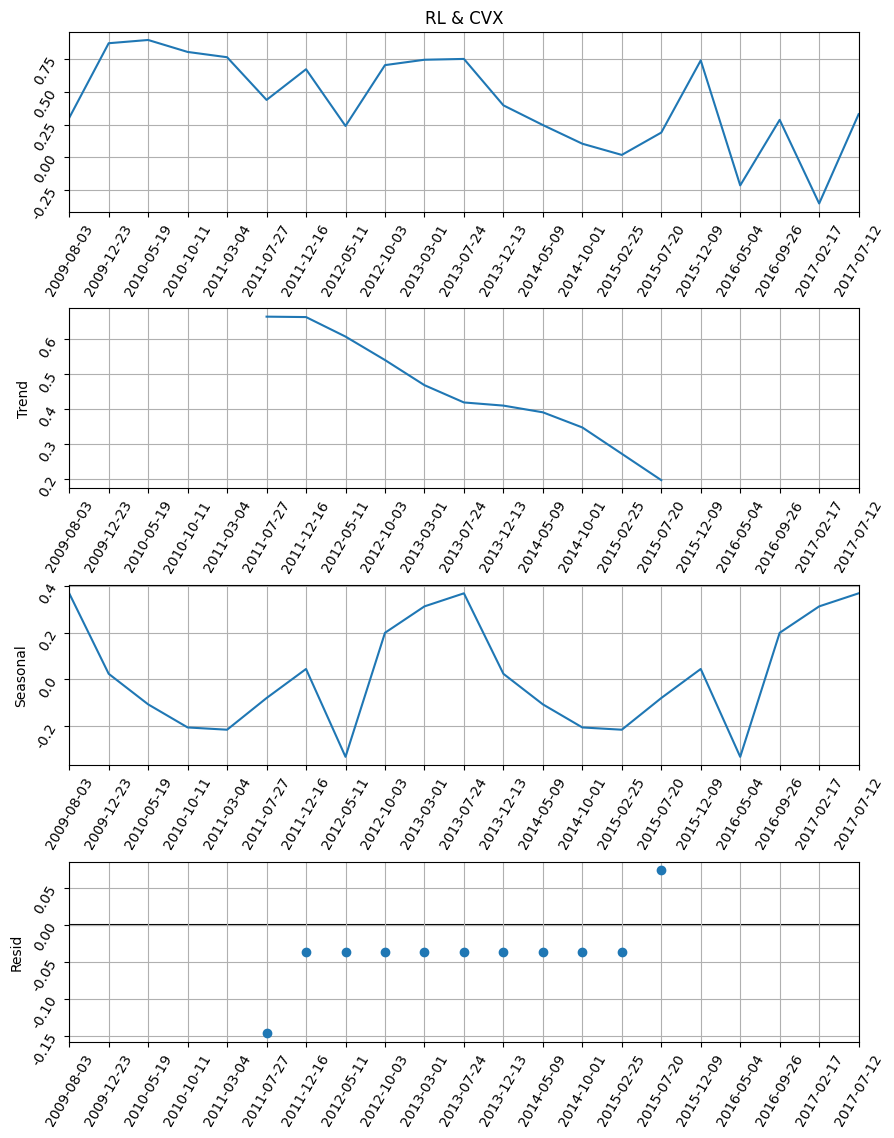

(10, 0.5463782504451181, 0.15478694088176692, -0.04606928854340583)

time: 498 ms (started: 2022-11-01 19:11:23 +00:00)


In [9]:
unseen_data_corr_df = gen_unseen_data_corr([items_implement[0], items_implement[1]])
stl_decompn(unseen_data_corr_df.iloc[0, ::], overview=True)

In [10]:
res_list = []
unseen_data_corr_df_concat = pd.DataFrame()
count = 0
for items in tqdm(combinations(items_implement, 2)):
    unseen_data_corr_df = gen_unseen_data_corr(items, time_period=time_period)
    lstm_input = unseen_data_corr_df.iloc[0,:20].values.reshape((-1, 20, 1))
    lstm_pred = lstm_model.predict(lstm_input)
    season_period, stl_resid, stl_trend_std, coef_reg_trend = stl_decompn(unseen_data_corr_df.iloc[0, :])
    items_res_dic = {"items": f"{items[0]} & {items[1]}",
                     "corr_ser_mean": unseen_data_corr_df.mean(axis=1)[0],
                     "corr_ser_std": unseen_data_corr_df.std(axis=1)[0],
                     "corr_season_period": season_period,
                     "corr_stl_resid": stl_resid,
                     "corr_stl_trend_std": stl_trend_std,
                     "corr_trend_coef": coef_reg_trend,
                     "lstm_pred": lstm_pred[0][0],
                     "ground_truth": unseen_data_corr_df.iloc[0, -1]}

    res_list.append(items_res_dic)
    unseen_data_corr_df['items'] = f"{items[0]} & {items[1]}"
    unseen_data_corr_df_concat = pd.concat([unseen_data_corr_df_concat, unseen_data_corr_df])

if save_raw_corr_data:
    unseen_data_corr_df_concat = unseen_data_corr_df_concat.set_index('items')
    unseen_data_corr_df_concat.to_csv(f"./results/{output_file_name}_raw_corr.csv", index=True)

0it [00:00, ?it/s]2022-11-01 19:11:24.701013: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 1s 1s/step


1it [00:01,  1.06s/it]

1/1 [==============================] - 0s 8ms/step


5it [00:01,  5.46it/s]

1/1 [==============================] - 0s 8ms/step


9it [00:01, 10.12it/s]

1/1 [==============================] - 0s 9ms/step


13it [00:01, 14.30it/s]

1/1 [==============================] - 0s 8ms/step


17it [00:01, 18.27it/s]

1/1 [==============================] - 0s 8ms/step


21it [00:01, 21.85it/s]

1/1 [==============================] - 0s 8ms/step


25it [00:01, 24.97it/s]

1/1 [==============================] - 0s 9ms/step


29it [00:01, 27.14it/s]

1/1 [==============================] - 0s 9ms/step


33it [00:02, 28.98it/s]

1/1 [==============================] - 0s 9ms/step


37it [00:02, 29.65it/s]

1/1 [==============================] - 0s 9ms/step


41it [00:02, 30.30it/s]

1/1 [==============================] - 0s 9ms/step


45it [00:02, 18.65it/s]

time: 2.42 s (started: 2022-11-01 19:11:24 +00:00)


In [11]:
res_df = pd.DataFrame(res_list)
res_df.to_csv(f"./results/{output_file_name}.csv", index=False)

time: 1.84 ms (started: 2022-11-01 19:11:26 +00:00)


# Display results

In [12]:
res_df = pd.read_csv(f"./results/{output_file_name}.csv")
display(res_df)

,items,corr_ser_mean,corr_ser_std,corr_season_period,corr_stl_resid,corr_stl_trend_std,corr_trend_coef,lstm_pred,ground_truth
0,RL & CVX,0.424903,0.358556,10,0.546378,0.154787,-0.046069,0.327231,0.329080
1,RL & SRE,0.190953,0.505713,10,0.682961,0.121800,-0.033396,0.293133,-0.646733
2,RL & PFE,0.315684,0.383996,9,0.640048,0.106715,-0.026128,0.305420,0.688240
3,RL & PCG,0.118185,0.502704,10,0.171971,0.095152,-0.026904,0.274669,-0.363489
4,RL & UTX,0.358892,0.568486,10,0.695509,0.267087,-0.079783,0.299756,-0.706079
5,RL & NTRS,0.246737,0.479720,10,0.661138,0.071518,-0.004433,0.344035,-0.383607
6,RL & INCY,0.171013,0.510106,10,0.648455,0.091230,-0.021144,0.261406,0.209279
7,RL & COP,0.383459,0.417165,10,1.394751,0.166667,-0.048037,0.299103,0.536173
8,RL & HRL,0.255742,0.429680,10,0.430691,0.144993,-0.043015,0.287645,0.306074
9,CVX & SRE,0.339658,0.408272,10,1.302155,0.054176,-0.003122,0.323348,-0.611277


time: 11.9 ms (started: 2022-11-01 19:11:26 +00:00)


In [13]:
def res_df_postprocess(target_df: pd.core.frame.DataFrame) -> None:
    target_df["error"] = target_df["ground_truth"] - target_df["lstm_pred"]
    target_df["absolute_err"] = target_df["error"].abs()
    quantile_mask = np.logical_and(res_df['error'] < np.quantile(res_df['error'], 0.75), res_df['error'] > np.quantile(res_df['error'], 0.25)).tolist()
    display(np.quantile(res_df['error'], 0.75), np.quantile(res_df['error'], 0.25))
    target_df['high_pred_performance'] = quantile_mask
    target_df['items[0]'] = target_df.apply(lambda row:row['items'].split(" & ")[0], axis=1)
    target_df['items[1]'] = target_df.apply(lambda row:row['items'].split(" & ")[1], axis=1)


res_df_postprocess(res_df)
display(res_df)

0.023598782260680795

-0.7276416673955606

,items,corr_ser_mean,corr_ser_std,corr_season_period,corr_stl_resid,corr_stl_trend_std,corr_trend_coef,lstm_pred,ground_truth,error,absolute_err,high_pred_performance,items[0],items[1]
0,RL & CVX,0.424903,0.358556,10,0.546378,0.154787,-0.046069,0.327231,0.329080,0.001849,0.001849,True,RL,CVX
1,RL & SRE,0.190953,0.505713,10,0.682961,0.121800,-0.033396,0.293133,-0.646733,-0.939866,0.939866,False,RL,SRE
2,RL & PFE,0.315684,0.383996,9,0.640048,0.106715,-0.026128,0.305420,0.688240,0.382820,0.382820,False,RL,PFE
3,RL & PCG,0.118185,0.502704,10,0.171971,0.095152,-0.026904,0.274669,-0.363489,-0.638158,0.638158,True,RL,PCG
4,RL & UTX,0.358892,0.568486,10,0.695509,0.267087,-0.079783,0.299756,-0.706079,-1.005835,1.005835,False,RL,UTX
5,RL & NTRS,0.246737,0.479720,10,0.661138,0.071518,-0.004433,0.344035,-0.383607,-0.727642,0.727642,False,RL,NTRS
6,RL & INCY,0.171013,0.510106,10,0.648455,0.091230,-0.021144,0.261406,0.209279,-0.052127,0.052127,True,RL,INCY
7,RL & COP,0.383459,0.417165,10,1.394751,0.166667,-0.048037,0.299103,0.536173,0.237070,0.237070,False,RL,COP
8,RL & HRL,0.255742,0.429680,10,0.430691,0.144993,-0.043015,0.287645,0.306074,0.018428,0.018428,True,RL,HRL
9,CVX & SRE,0.339658,0.408272,10,1.302155,0.054176,-0.003122,0.323348,-0.611277,-0.934625,0.934625,False,CVX,SRE


time: 20.6 ms (started: 2022-11-01 19:11:26 +00:00)


---

In [14]:
def plot_stock_freq(target_df: pd.core.frame.DataFrame, title: str) -> None:
    stocks_show_freq = target_df.loc[target_df['high_pred_performance'] == True, ['items[0]','items[1]']].stack().value_counts().to_dict()
    plt.figure(figsize=(80, 10), dpi=100)
    plt.bar(range(len(stocks_show_freq)), list(stocks_show_freq.values()))
    plt.xticks(range(len(stocks_show_freq)), list(stocks_show_freq.keys()), rotation=60)
    plt.title(F"{title}_items appearence frequence")
    plt.savefig(f"./results/items_appearence_frequence_{title}.png")
    plt.show()
    plt.close()

time: 663 µs (started: 2022-11-01 19:11:26 +00:00)


In [15]:
display(f"mse :{(res_df['error']**2).mean()}",
        f"std of square_err :{(res_df['error']**2).std()}",
        f"rmse :{np.sqrt((res_df['error']**2).mean())}",
        f"mae : {res_df['absolute_err'].mean()}",
        f"std of abs_err: {res_df['absolute_err'].std()}",
        f"sklearn mse: {mean_squared_error(res_df['ground_truth'], res_df['lstm_pred'])}")

'mse :0.3239629367232207'

'std of square_err :0.32258322524428606'

'rmse :0.569177421129142'

'mae : 0.4700763818066007'

'std of abs_err: 0.3245486705196647'

'sklearn mse: 0.3239629367232207'

time: 6.51 ms (started: 2022-11-01 19:11:26 +00:00)


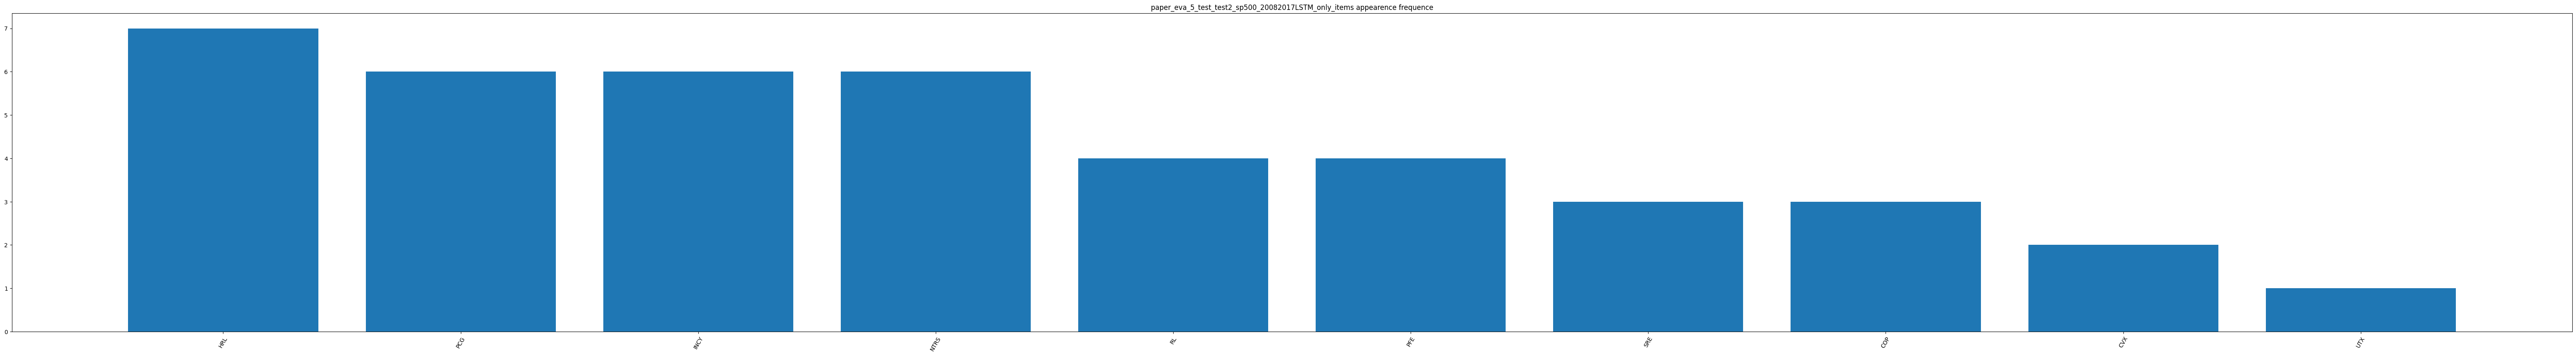

time: 660 ms (started: 2022-11-01 19:11:26 +00:00)


In [16]:
plot_stock_freq(res_df, fig_title)